In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("water_potability.csv")

In [3]:
df['Potability'].value_counts()/df.shape[0]

0    0.60989
1    0.39011
Name: Potability, dtype: float64

In [4]:
df.shape

(3276, 10)

In [5]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [6]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [7]:
#Replacing NaNs with means
na_cols = df.isnull().sum()[df.isnull().sum() != 0].index.tolist()

df[na_cols] = df[na_cols].fillna(df[na_cols].mean())

In [8]:
cols = df.columns.tolist()
cols.remove('Potability')

### Time to Plot

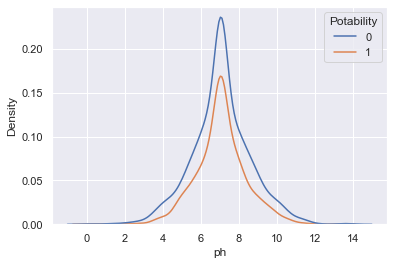

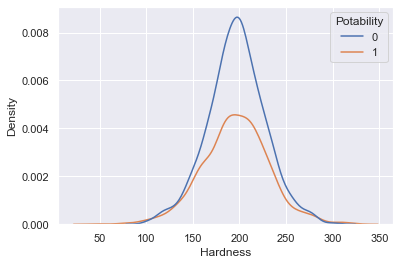

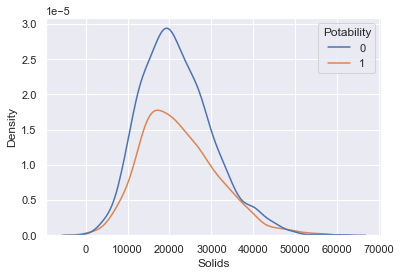

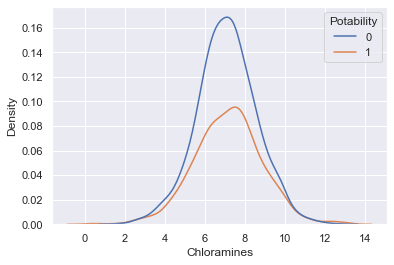

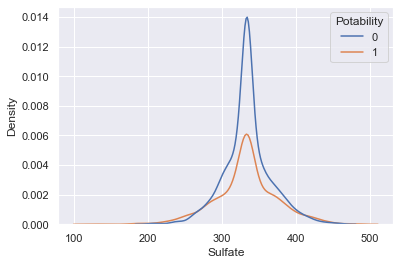

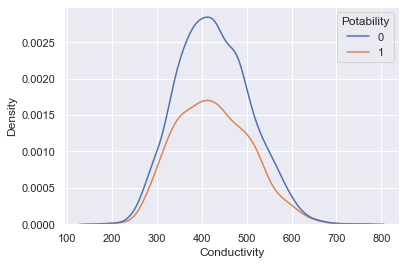

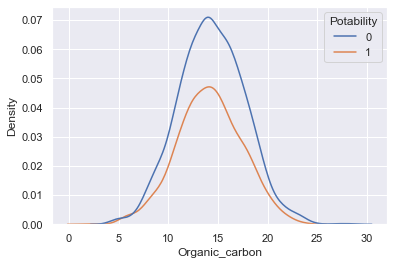

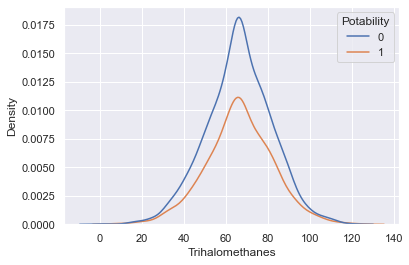

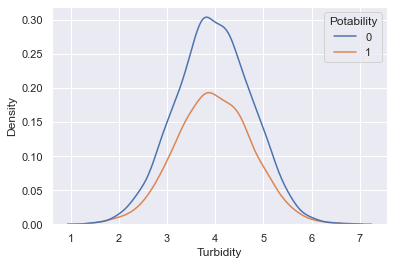

In [9]:
for i in cols:
    sns.kdeplot(data=df,x=i,hue='Potability')
    plt.xlabel(i)
    plt.show()

This looks very clean at first glance. All features seem to be roughly normally distributed. But I don't see any class separations. Let's look at pairplots.

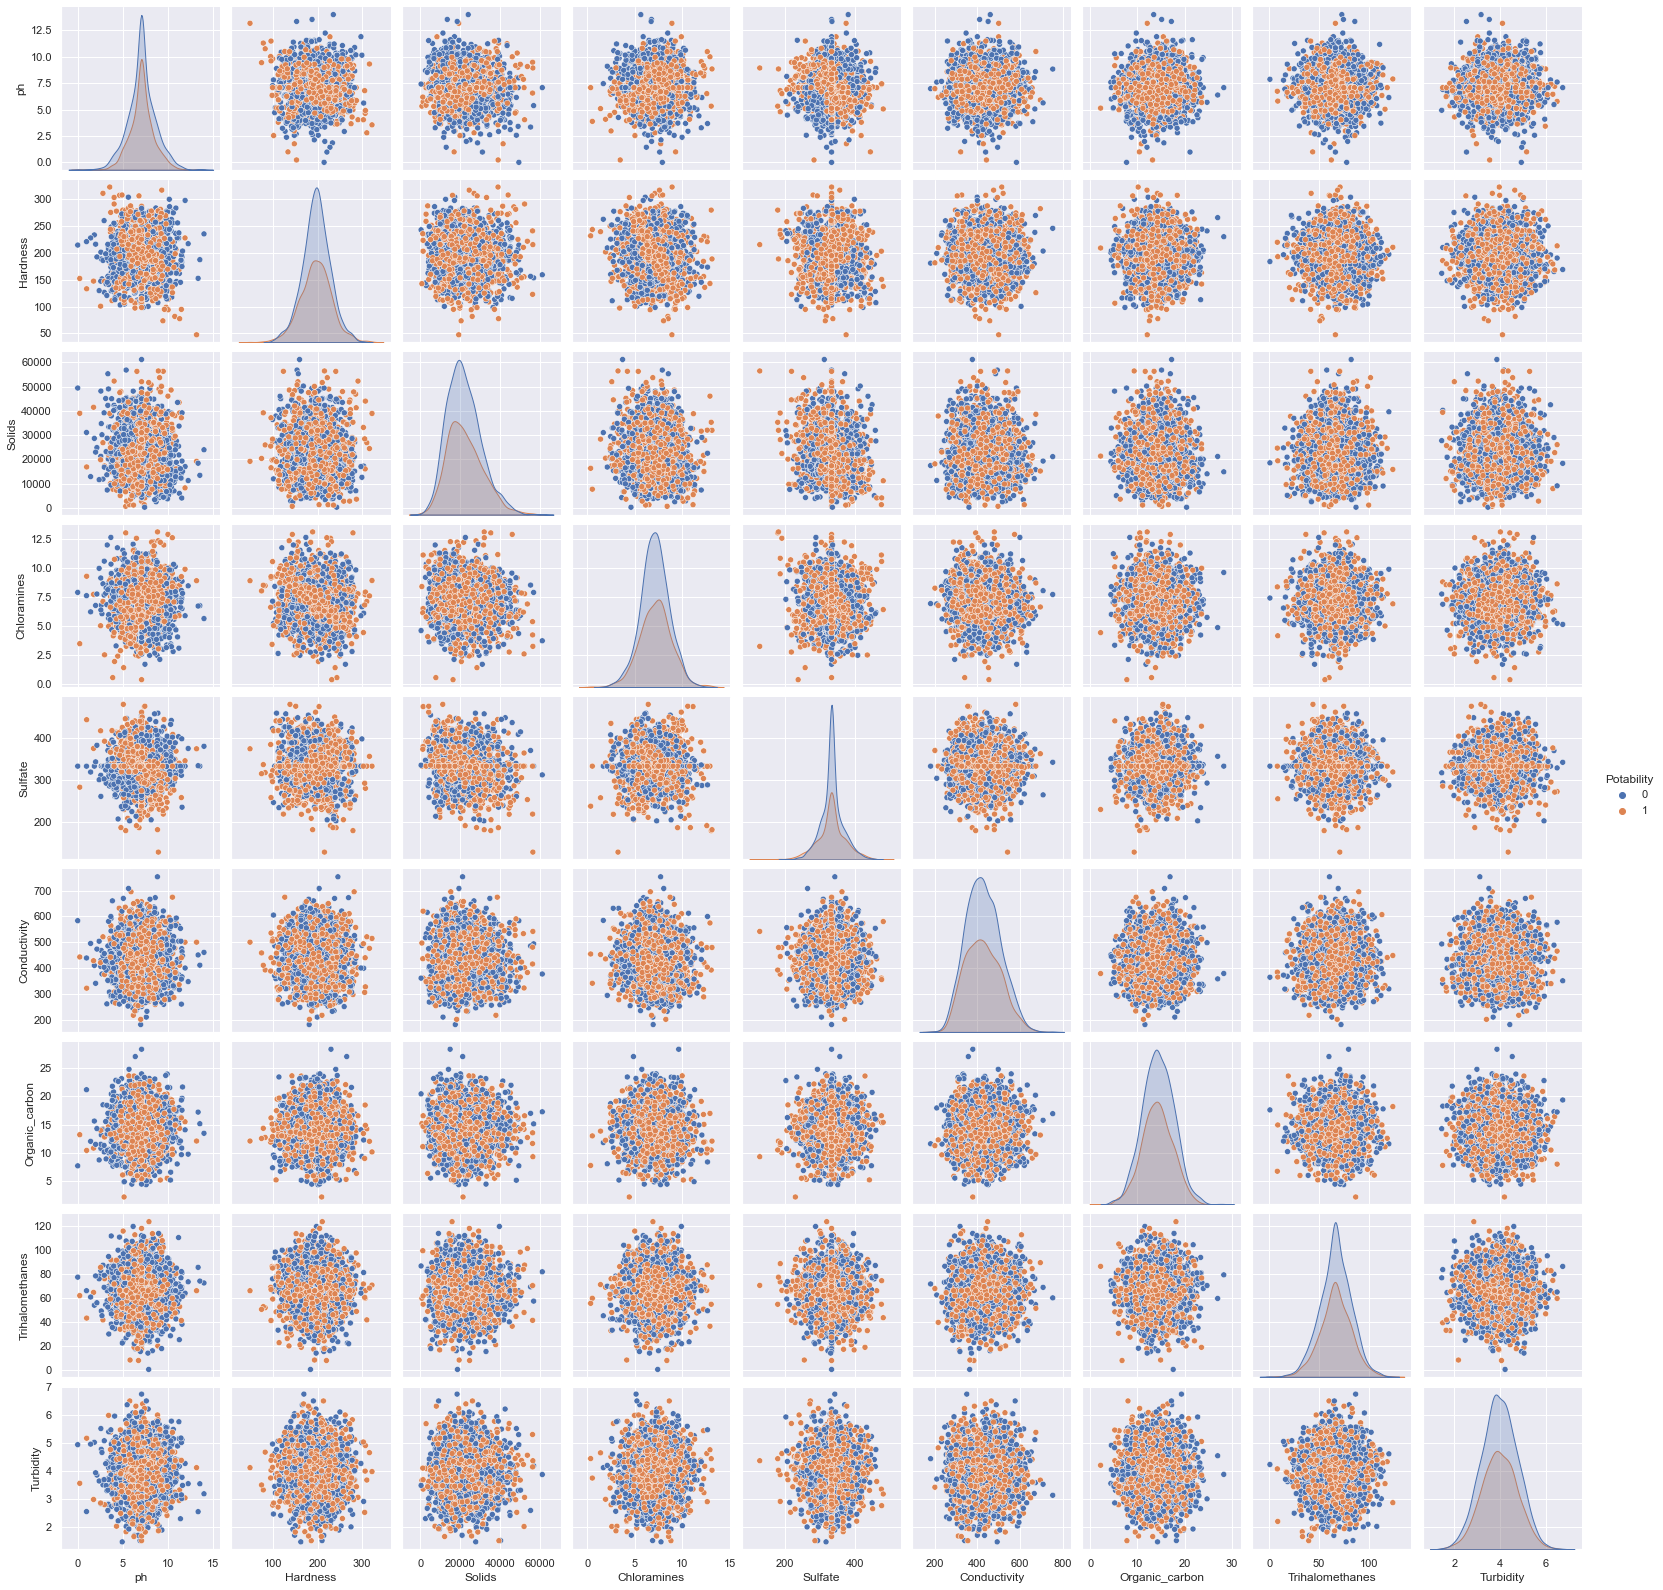

In [10]:
sns.pairplot(data=df,hue='Potability')
plt.show()

Again, similar story - clean data, but no class separation. 

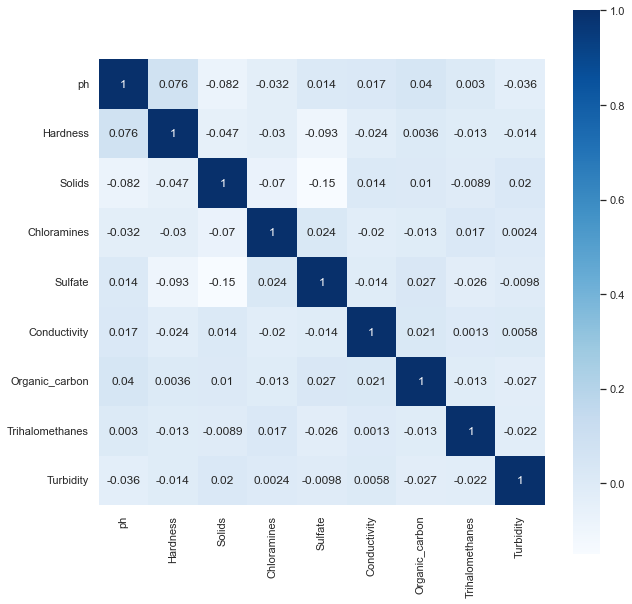

In [11]:
corr = df.drop('Potability',axis=1).corr()
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr,square=True,annot=True,cmap='Blues',cbar=True)
plt.show()

### Model Fitting

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Potability',axis=1),df['Potability'],
                                                    test_size=0.2,random_state=3)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
y_train.value_counts()/y_train.shape[0], y_test.value_counts()/y_test.shape[0]

(0    0.611069
 1    0.388931
 Name: Potability, dtype: float64,
 0    0.605183
 1    0.394817
 Name: Potability, dtype: float64)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
classifiers = [LogisticRegression(),GaussianNB(), DecisionTreeClassifier(),
               LGBMClassifier(), CatBoostClassifier(verbose=False),XGBClassifier()]

scores = pd.DataFrame(columns=['Classifier','TestScore','TrainScore','TestRecall','TrainRecall'])

for i in classifiers:
    i.fit(X_train, y_train)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    scores.loc[len(scores.index)] = [i.__class__.__name__,
                                     accuracy_score(y_test,y_pred_test),accuracy_score(y_train,y_pred_train),
                                     recall_score(y_test,y_pred_test),recall_score(y_train,y_pred_train)]

[10:26:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dasab\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [20]:
scores.sort_values(by='TestRecall')

,Classifier,TestScore,TrainScore,TestRecall,TrainRecall
0,LogisticRegression,0.605183,0.611832,0.000000,0.001963
1,GaussianNB,0.629573,0.625954,0.258687,0.226693
4,CatBoostClassifier,0.678354,0.884733,0.378378,0.725221
3,LGBMClassifier,0.660061,0.952672,0.386100,0.889107
5,XGBClassifier,0.631098,0.994656,0.409266,0.986261
2,DecisionTreeClassifier,0.588415,1.000000,0.501931,1.000000


Performance is pretty bad, even wrt accuracy, forget about recall. A dummy classifier which always predicts 0 will get ~60% accuracy. We aren't doing much better than that on the TestScore. Our workhorse models, Catboost, LGBM and XGBoost, are all overfitting. All troubling signs. Lets see if a neural network would do any better.

### Implementing a Neural Network

In [21]:
import torch
import torch.nn as nn

trainX, testX, trainY, testY = train_test_split(df.drop('Potability',axis=1),df['Potability'],test_size=0.2,
                                                random_state=3)

X_train, X_valid, y_train, y_valid = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(testX)

y_train = y_train.to_numpy().reshape(-1,1)
y_valid = y_valid.to_numpy().reshape(-1,1)
y_test = testY.to_numpy().reshape(-1,1)

def to_tensor(X,y):
    return torch.from_numpy(X).to(torch.float), torch.from_numpy(y).to(torch.float)

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)
Xt_test, yt_test = to_tensor(X_test, y_test)

In [22]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(9,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    epoch_loss_train = list()
    epoch_loss_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        
        epoch_loss_train.append(loss.item())
        epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    return model

def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

def model_recall(X,y):
    y_pred = model_prediction(X)
    return recall_score(y,y_pred)    

def model_scores(X,y):
    print("Accuracy: %s"%model_accuracy(X,y))
    print("Recall:   %s"%model_recall(X,y))

Epoch 100, Loss 0.606011688709259
Early Stopping at Epoch 158
Test Set
Accuracy: 0.676829268292683
Recall:   0.3745173745173745

Training Set
Accuracy: 0.7080152671755725
Recall:   0.40399002493765584

Validation Set
Accuracy: 0.6603053435114504
Recall:   0.37327188940092165


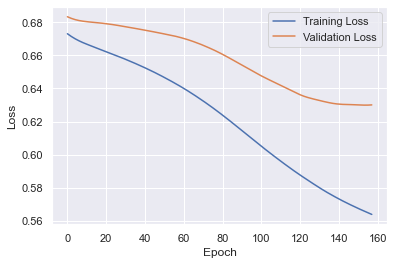

In [23]:
n_epoch = 1000
patience = 2
lr = 0.001

model = NN()
model = train(model, n_epoch, patience, lr, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("\nTraining Set")
model_scores(Xt_train, yt_train)
print("\nValidation Set")
model_scores(Xt_valid, yt_valid)

Similarly dismal performance. Lets look at our data once more. <br>
Let's visualize the data using the manifold techniques: UMAP and t-SNE. I think these will confirm that there really isn't any class separation in the data.

### Visualizing the Data using Manifold Techniques

C:\Users\dasab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dasab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


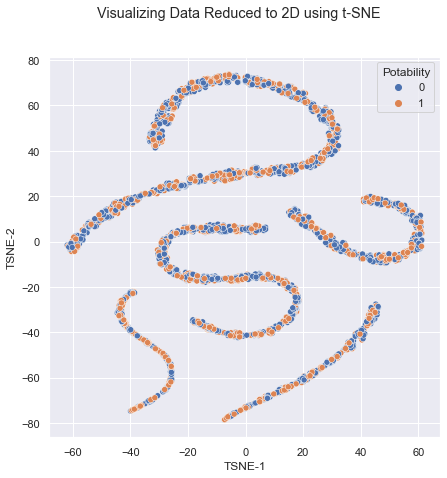

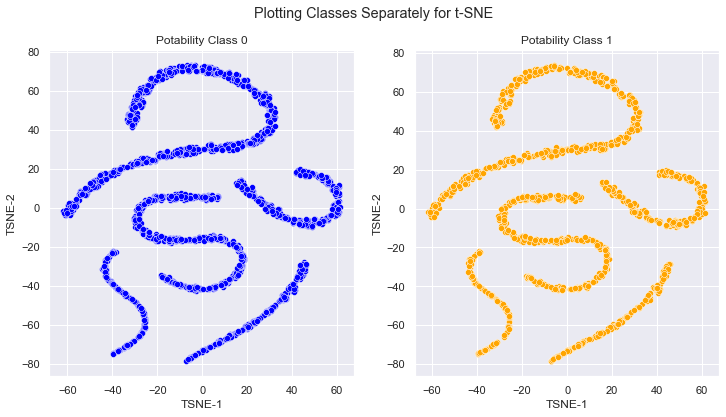

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(df.drop('Potability',axis=1))
X_tsne = pd.DataFrame(X_tsne,columns=['TSNE-1','TSNE-2'])
df_tsne = pd.concat([X_tsne,df['Potability']],axis=1)

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=df_tsne,x='TSNE-1',y='TSNE-2',hue='Potability')
plt.suptitle("Visualizing Data Reduced to 2D using t-SNE")
ax.legend(bbox_to_anchor=(1,1),title='Potability')
plt.show()

#classes plotted separately
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
fig.suptitle("Plotting Classes Separately for t-SNE")
sns.scatterplot(data=df_tsne.loc[df_tsne['Potability']==0],x='TSNE-1',y='TSNE-2',ax=ax1,color='Blue')
ax1.set_title("Potability Class 0")
sns.scatterplot(data=df_tsne.loc[df_tsne['Potability']==1],x='TSNE-1',y='TSNE-2',ax=ax2,color='Orange')
ax2.set_title("Potability Class 1")
plt.show()

Confirmed! There is structure in the data, but inspite of the structure, there is very little class separation. Not sure how to even get any class separation, using any method.